In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
from pygame import mixer, time
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from game_simulation import CoinGameSimulation
from game_browser import CoinGameBrowser
from simulate_strategy import simulate_strategy

pygame 2.1.2 (SDL 2.0.18, Python 3.10.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


### Strategy 4: make use of simple Bayesian reasoning.
This strategy uses simple Bayeisan resoning to determine the best strategy to play.

- $p$: The parameter of the Bernoulli distribution of L, is the probability of the opponent being fair.
- $L$:  Bernouilli distribution with unkown parameter p. Determines if the opponent is a cheater or not.
- $\theta$: The parameter of the Bernoulli distribution of H.
- $H_{1:N}$: Bernouilli distribution with parameter $\theta$ and $N$ samples. Gives the number of heads.

We use Bayes rule to get:
$$
\begin{align*}
P(L | H_{1:N}) &= \frac{P(H_{1:N} | L) \cdot P(L)}{P(H_{1:N})} \\
               &= \frac{\sum_{\theta=0}^1 P(H_{1:N} | L) \cdot P(L)}{P(H_{1:N})} \\
               &\propto \sum_{\theta=0}^1 P(H_{1:N} | L) \cdot P(L)\\
\end{align*}
$$

We know that:
$$
p = 0.5
$$
$$
\theta=0.5 \text{ if } L=0, \text{ and } \theta=0.75 \text{ if } L=1.
$$
<!--
Meaning that:

 $$
P(\theta | L=0) = 
\begin{cases}
& 1\quad \text{if } \theta=0.5 \\
& 0\quad \text{otherwise} \\
\end{cases} \\

P(\theta | L=1) = 
\begin{cases}
& 1\quad \text{if } \theta=0.75 \\
& 0\quad \text{otherwise} \\
\end{cases} \\

$$ -->

In [3]:
class StrategyBayseian:

    def __init__(self, 
                 threshold = 0.75, 
                 n = 50,
                 flip_5_at_start = False):
        assert 0 <= threshold <= 1
        assert 0 <= n <= 500
        self.threshold = threshold 
        self.flip_5_at_start = flip_5_at_start

        n_heads_array = np.arange(n).reshape(n, 1)
        n_tails_array = np.arange(n)
        p = np.zeros((n, n, 2))
        p[:, :, 0] = 0.5 ** n_heads_array * 0.5 ** n_tails_array
        p[:, :, 1] = 0.75 ** n_heads_array * (1-0.75) ** n_tails_array
        self.p = p / p.sum(axis=2, keepdims=True)

    def set_theshold(self, threshold):
        assert 0 <= threshold <= 1
        self.threshold = threshold

    def show_p(self, shape=None):
        if shape is None:
            shape = self.p.shape
        plt.imshow(self.p[:shape[0], :shape[1], 0])
        plt.title("Probability of being a fair player")
        plt.colorbar()
        plt.clim(0,1)
        plt.xlabel('Number of tails')
        plt.ylabel('Number of heads')
        plt.show()

    def get_p(self):
        return self.p

    def strategy(self, n_heads, n_tails, flips_left):
        if self.flip_5_at_start and n_heads + n_tails == 0 and flips_left >= 5:
            return 1
        
        p = self.p[n_heads, n_tails, :]

        if np.max(p) > self.threshold or flips_left == 0:
            label = np.argmax(p)
            return label + 2
        else:
            return 0

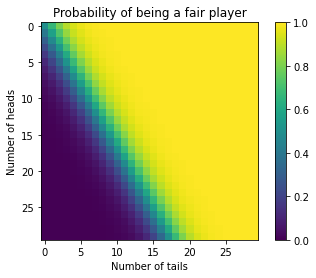

In [6]:
g = CoinGameSimulation()
scores = []
strat = StrategyBayseian(n=500)
strat.show_p(shape=(30, 30))

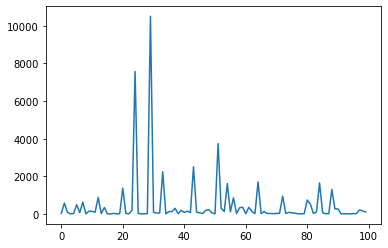

In [5]:
for i in range(100):
    (n_heads, n_tails, flips_left) = g.reset()
    done = False
    while not done:
        action = strat.strategy(n_heads, n_tails, flips_left)
        (n_heads, n_tails, flips_left), reward, done, info = g.step(action)

    score = info["score"]
    scores.append(score)

plt.plot(scores, label="scores")
plt.show()

Here I simulate the strategy for different thesholds.

In [45]:
strat.set_theshold(0.78)
simulate_strategy(strat.strategy, n_simulations=100)

Score           mean: 171.55, std: 398.13, median  49, min:   0, max: 2651
Labels per game mean: 213.03, std: 488.23, median  63, min:   3, max: 3252
Flips per game  mean: 1442.06, std: 3271.43, median 454, min:  18, max: 21865
Flips per label mean:  6.77, std:  4.93, median   5, min:   0, max:  59
Reward          mean: -0.07, std:  6.84, median  -1, min: -30, max:  15
Accuracy: 0.805, Precision: 0.808, Recall: 0.800, F1-score: 0.804


In [49]:
strat.flip_5_at_start = True

In [50]:
strat.set_theshold(0.78)
simulate_strategy(strat.strategy, n_simulations=100)

Score           mean: 154.17, std: 266.53, median  61, min:   2, max: 1574
Labels per game mean: 186.00, std: 316.54, median  75, min:   5, max: 1870
Flips per game  mean: 1472.17, std: 2499.52, median 592, min:  43, max: 14860
Flips per label mean:  7.91, std:  4.64, median   6, min:   0, max:  58
Reward          mean: -0.13, std:  8.65, median  -1, min: -30, max:  15
Accuracy: 0.829, Precision: 0.823, Recall: 0.834, F1-score: 0.829


In [18]:
g = CoinGameBrowser()
log_file = "logs/discard.txt"

In [19]:
with open(log_file, 'w') as f:
    f.write('Score,Flips left,Heads,Tails,Action,Reward\n')

In [ ]:
i = 0
try:
    while True:
        if i > 0:
            (n_heads, n_tails, flips_left) = g.reset()
        i += 1
        done = False
        while not done:
            action = strat.strategy(n_heads, n_tails, flips_left)
            (n_heads, n_tails, flips_left), reward, done, info = g.step(action)
            score = info["score"]
            print(f'{score=}, {flips_left=}, {n_heads=}, {n_tails=}, {action=}, {reward=}   ', end='\r')            
            with open(log_file, 'a') as f:
                f.write(f'{score:3},{flips_left:3},{n_heads:2},{n_tails:2},{action:2},{reward:3}\n')
        if score > 200:
            break
except Exception as e:
    print(e)

mixer.init()
while True:
    sound = mixer.Sound("coin-win-notification.wav")
    sound.play()
    time.wait(int(sound.get_length() * 1000))

In [27]:
g.driver.close()